# Lossless compression

This notebook reproduces the results of the `Lossless compression` section in the paper.

We assume the `ephys-compression/scripts/benchmark-lossless.py` has been run and the `../data/ephys-compression-results/results-lossless/benchmark-lossless.csv"` is available.

In [1]:
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

import pandas as pd
import seaborn as sns

from utils import prettify_axes, stat_test

%matplotlib inline

In [3]:
figsize_single = (10, 5)
figsize_multi_2rows = (10, 9)
figsize_multi_3rows = (10, 12)
figsize_multi_4rows = (10, 12)

In [4]:
data_folder = Path("../data")
results_folder = Path("../results")

save_fig = True
fig_folder = results_folder / "figures"
fig_folder.mkdir(exist_ok=True, parents=True)

results_lossless_folder = data_folder / "ephys-compression-results" / "results-lossless"

In [5]:
res = pd.read_csv(results_lossless_folder / "benchmark-lossless.csv", index_col=False)
res_delta = pd.read_csv(results_lossless_folder / "benchmark-lossless-delta.csv", index_col=False)
res_pre = pd.read_csv(results_lossless_folder / "benchmark-lossless-preprocessing.csv", index_col=False)

In [6]:
probe_names = {"Neuropixels1.0": "NP1",
               "Neuropixels2.0": "NP2"}
for probe, probe_name in probe_names.items():
    res.loc[res.query(f"probe == '{probe}'").index, "probe"] = probe_name
    res_delta.loc[res_delta.query(f"probe == '{probe}'").index, "probe"] = probe_name
    res_pre.loc[res_pre.query(f"probe == '{probe}'").index, "probe"] = probe_name

In [7]:
# color palettes
cmap = plt.get_cmap("Paired")
compressor_palette = {}
ctypes = ["blosc", "numcodecs", "audio"]
num_compressors = len(np.unique(res.compressor))
i = 0
for ctype in ctypes:
    res_ctype = res.query(f"compressor_type == '{ctype}'")
    for comp in np.unique(res_ctype.sort_values("compressor").compressor):
        compressor_palette[comp]  = cmap(i / num_compressors)
        i += 1
compressor_palette_dark = compressor_palette.copy()
darker = 0.2

for comp, color in compressor_palette.items():
    col_dark = (max(color[0] - darker, 0), max(color[1] - darker, 0), max(color[2] - darker, 0), 0.8)
    compressor_palette_dark[comp] = col_dark

standard_palette = "Greys"

In [8]:
test_columns=["CR", "cspeed_xrt", "dspeed10s_xrt"]

## LSB correction

In [12]:
res_aind = res.query("dataset != 'ibl-np1'")

In [13]:
rest_lsb = stat_test(res_aind, column_group_by="lsb", 
                     test_columns=test_columns, verbose=True)


Testing metric CR

Sample 1: false - n. 2700
Sample 2: true - n. 2700
Non normal samples: using non parametric tests
2-sample test
P-value <1e-10 (4.3380626562434074e-259) - effect size: -0.99

Testing metric cspeed_xrt

Sample 1: false - n. 2700
Sample 2: true - n. 2700
Non normal samples: using non parametric tests
2-sample test
P-value <1e-10 (6.349340877987561e-52) - effect size: 0.417

Testing metric dspeed10s_xrt

Sample 1: false - n. 2700
Sample 2: true - n. 2700
Non normal samples: using non parametric tests
2-sample test
P-value <1e-2 (0.0021623672547386205) - effect size: -0.084


In [14]:
# select LSB = True
res_lsb = res.query("lsb != 'false'")

In [15]:
rest_chunk = stat_test(res_lsb, column_group_by="chunk_duration", 
                       test_columns=test_columns, verbose=True)


Testing metric CR

Sample 1: 0.1s - n. 1200
Sample 2: 10s - n. 1200
Sample 3: 1s - n. 1200
Non normal samples: using non parametric tests
Population test
Non significant

Testing metric cspeed_xrt

Sample 1: 0.1s - n. 1200
Sample 2: 10s - n. 1200
Sample 3: 1s - n. 1200
Non normal samples: using non parametric tests
Population test
Post-hoc


,10s,1s,0.1s
10s,1.000000e+00,1.653591e-02,3.406060e-20
1s,1.653591e-02,1.000000e+00,9.433171e-31
0.1s,3.406060e-20,9.433171e-31,1.000000e+00


Post-hoc


,10s,1s,0.1s
10s,NaN,NaN,NaN
1s,NaN,NaN,NaN
0.1s,<1e-10,<1e-10,NaN


Cohen's d


,10s,1s,0.1s
10s,NaN,NaN,NaN
1s,NaN,NaN,NaN
0.1s,-0.485681,-0.57229,NaN



Testing metric dspeed10s_xrt

Sample 1: 0.1s - n. 1200
Sample 2: 10s - n. 1200
Sample 3: 1s - n. 1200
Non normal samples: using non parametric tests
Population test
Post-hoc


,10s,1s,0.1s
10s,1.000000,0.000048,0.743439
1s,0.000048,1.000000,0.000016
0.1s,0.743439,0.000016,1.000000


Post-hoc


,10s,1s,0.1s
10s,NaN,NaN,NaN
1s,<1e-4,NaN,NaN
0.1s,NaN,<1e-4,NaN


Cohen's d


,10s,1s,0.1s
10s,NaN,NaN,NaN
1s,0.374105,NaN,NaN
0.1s,NaN,-0.419141,NaN


## Chunk size

In [16]:
res_chunk = res_lsb.query("chunk_duration == '1s'")

In [17]:
rest_probe = stat_test(res_chunk, column_group_by="probe", 
                       test_columns=test_columns, verbose=True)


Testing metric CR

Sample 1: NP1 - n. 600
Sample 2: NP2 - n. 600
Non normal samples: using non parametric tests
2-sample test
P-value <1e-10 (1.0101929255005249e-60) - effect size: 1.005

Testing metric cspeed_xrt

Sample 1: NP1 - n. 600
Sample 2: NP2 - n. 600
Non normal samples: using non parametric tests
2-sample test
Non significant

Testing metric dspeed10s_xrt

Sample 1: NP1 - n. 600
Sample 2: NP2 - n. 600
Non normal samples: using non parametric tests
2-sample test
Non significant


## Probe type

### Figure 1

In [ ]:
fig_1, axs = plt.subplots(ncols=3, nrows=3, figsize=figsize_multi_3rows)

sns.boxenplot(data=res_aind, x="lsb", y="CR", ax=axs[0, 0], palette=standard_palette)
sns.boxenplot(data=res_aind, x="lsb", y="cspeed_xrt", ax=axs[0, 1], palette=standard_palette)
sns.boxenplot(data=res_aind, x="lsb", y="dspeed10s_xrt", ax=axs[0, 2], palette=standard_palette)

axs[0, 0].set_xlabel("")
axs[0, 2].set_xlabel("")
axs[0, 1].set_xlabel("LSB correction")

axs[0, 0].set_xticklabels(["off", "on"])
axs[0, 1].set_xticklabels(["off", "on"])
axs[0, 2].set_xticklabels(["off", "on"])

axs[0, 0].set_ylabel("Compression Ratio")
axs[0, 1].set_ylabel("Compression speed (xRT)")
axs[0, 2].set_ylabel("Decompression speed (xRT)")


chunk_order = ["0.1s", "1s", "10s"]

sns.boxenplot(data=res_lsb, x="chunk_duration", y="CR", ax=axs[1, 0], palette=standard_palette,
              order=chunk_order)
sns.boxenplot(data=res_lsb, x="chunk_duration", y="cspeed_xrt", ax=axs[1, 1], palette=standard_palette,
              order=chunk_order)
sns.boxenplot(data=res_lsb, x="chunk_duration", y="dspeed10s_xrt", ax=axs[1, 2], palette=standard_palette,
              order=chunk_order)

axs[1, 0].set_xlabel("")
axs[1, 1].set_xlabel("Chunk duration (s)")
axs[1, 2].set_xlabel("")

axs[1, 0].set_xticklabels(["0.1", "1", "10"])
axs[1, 1].set_xticklabels(["0.1", "1", "10"])
axs[1, 2].set_xticklabels(["0.1", "1", "10"])

axs[1, 0].set_ylabel("Compression Ratio")
axs[1, 1].set_ylabel("Compression speed (xRT)")
axs[1, 2].set_ylabel("Decompression speed (xRT)")

probe_order = ["NP1", "NP2"]


sns.boxenplot(data=res_chunk, x="probe", y="CR", ax=axs[2, 0], palette=standard_palette,
              order=probe_order)
sns.boxenplot(data=res_chunk, x="probe", y="cspeed_xrt", ax=axs[2, 1], palette=standard_palette,
              order=probe_order)
sns.boxenplot(data=res_chunk, x="probe", y="dspeed10s_xrt", ax=axs[2, 2], palette=standard_palette,
              order=probe_order)

axs[2, 0].set_xlabel("")
axs[2, 1].set_xlabel("Probe type")
axs[2, 2].set_xlabel("")

axs[2, 0].set_xticklabels(["NP1", "NP2"])
axs[2, 1].set_xticklabels(["NP1", "NP2"])
axs[2, 2].set_xticklabels(["NP1", "NP2"])

axs[2, 0].set_ylabel("Compression Ratio")
axs[2, 1].set_ylabel("Compression speed (xRT)")
axs[2, 2].set_ylabel("Decompression speed (xRT)")

fig_1.subplots_adjust(wspace=0.5, hspace=0.3)
prettify_axes(axs, label_fs=12)

In [ ]:
if save_fig:
    fig_1.savefig(fig_folder / "fig1.pdf")

## General compressors 

We start by comparing compression options readily available via the Blosc meta-compressor in ZARR

In [18]:
res_zarr = res_chunk.query(f"compressor_type != 'audio'")

In [19]:
res_zarr_np1 = res_zarr.query("probe == 'NP1'")
res_zarr_np2 = res_zarr.query("probe == 'NP2'")

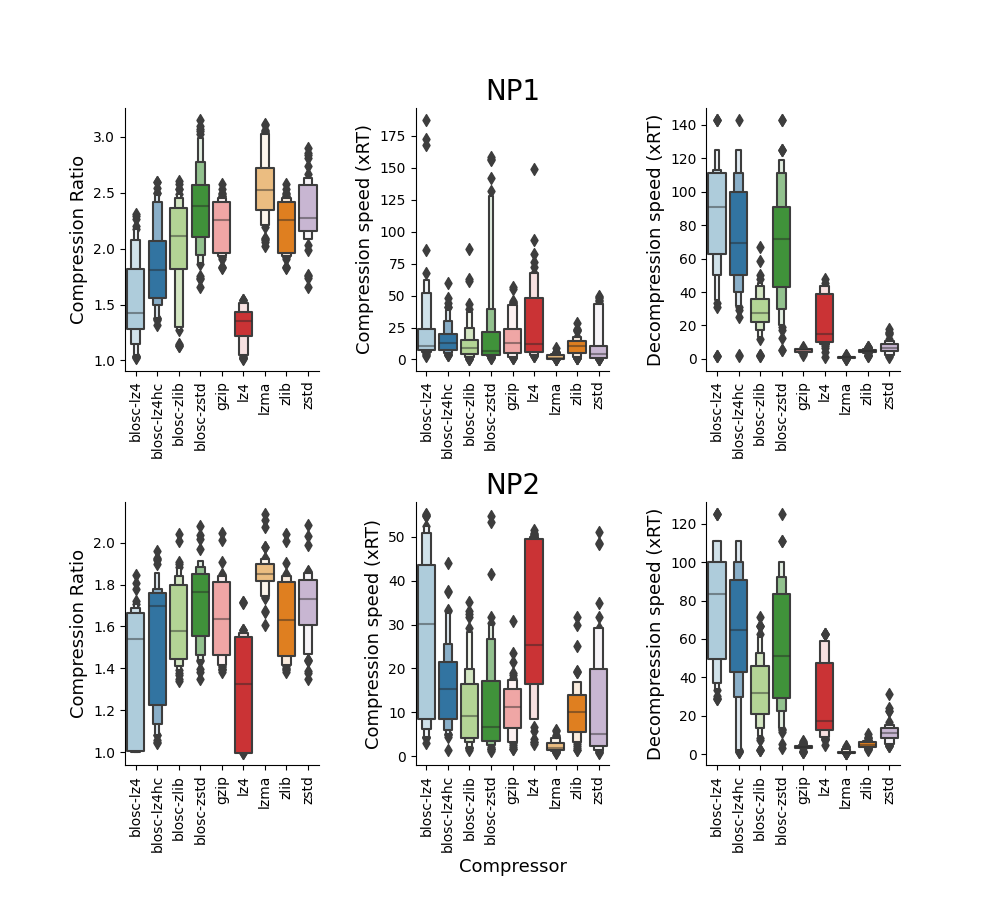

In [20]:
fig_2, axs = plt.subplots(ncols=3, nrows=2, figsize=figsize_multi_2rows)

order = sorted(np.unique(res_zarr_np1.compressor))

sns.boxenplot(data=res_zarr_np1, x="compressor", y="CR", ax=axs[0, 0], order=order,
              palette=compressor_palette)
sns.boxenplot(data=res_zarr_np1, x="compressor", y="cspeed_xrt", ax=axs[0, 1], order=order,
              palette=compressor_palette)
sns.boxenplot(data=res_zarr_np1, x="compressor", y="dspeed10s_xrt", ax=axs[0, 2], order=order,
              palette=compressor_palette)

axs[0, 0].set_xlabel("")
axs[0, 1].set_xlabel("")
axs[0, 2].set_xlabel("")

axs[0, 0].set_ylabel("Compression Ratio")
axs[0, 1].set_ylabel("Compression speed (xRT)")
axs[0, 2].set_ylabel("Decompression speed (xRT)")

axs[0, 0].set_xticklabels(axs[0, 0].get_xticklabels(), rotation=90)
axs[0, 1].set_xticklabels(axs[0, 1].get_xticklabels(), rotation=90)
axs[0, 2].set_xticklabels(axs[0, 2].get_xticklabels(), rotation=90)

sns.boxenplot(data=res_zarr_np2, x="compressor", y="CR", ax=axs[1, 0], order=order,
              palette=compressor_palette)
sns.boxenplot(data=res_zarr_np2, x="compressor", y="cspeed_xrt", ax=axs[1, 1], order=order,
              palette=compressor_palette)
sns.boxenplot(data=res_zarr_np2, x="compressor", y="dspeed10s_xrt", ax=axs[1, 2], order=order,
              palette=compressor_palette)

axs[1, 0].set_xlabel("")
axs[1, 1].set_xlabel("Compressor")
axs[1, 2].set_xlabel("")

axs[1, 0].set_ylabel("Compression Ratio")
axs[1, 1].set_ylabel("Compression speed (xRT)")
axs[1, 2].set_ylabel("Decompression speed (xRT)")

axs[1, 0].set_xticklabels(axs[1, 0].get_xticklabels(), rotation=90)
axs[1, 1].set_xticklabels(axs[1, 1].get_xticklabels(), rotation=90)
axs[1, 2].set_xticklabels(axs[1, 2].get_xticklabels(), rotation=90)

axs[0, 1].set_title("NP1", fontsize=20)
axs[1, 1].set_title("NP2", fontsize=20)

prettify_axes(axs, label_fs=13)
fig_2.subplots_adjust(wspace=0.5, hspace=0.5, bottom=0.15)

In [ ]:
display(res_zarr.groupby(["probe", "compressor"])["session"].count())

In [ ]:
res_zarr.groupby(["probe", "compressor"])[["CR", "cspeed_xrt", "dspeed10s_xrt"]].median().round(2)

In [ ]:
res_zarr.groupby(["probe", "compressor"])[["CR", "cspeed_xrt", "dspeed10s_xrt"]].std().round(2)

In [ ]:
if save_fig:
    fig_2.savefig(fig_folder / "fig2.pdf")

## Shuffling

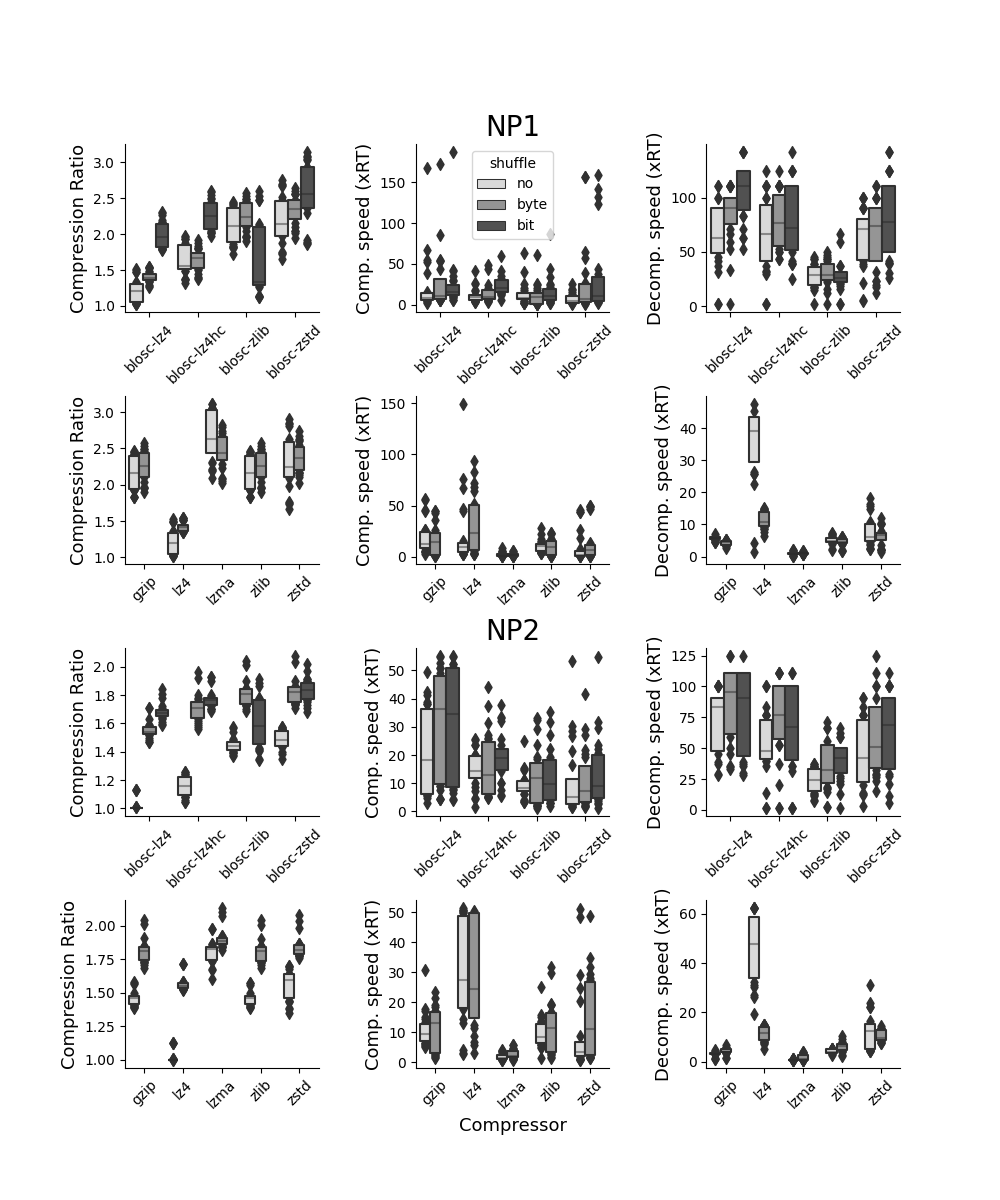

In [24]:
color = "Greys"
shuffle_order = ["no", "byte", "bit"]

fig_3, axs = plt.subplots(ncols=3, nrows=4, figsize=figsize_multi_4rows)
res_blosc = res_zarr_np1.query("compressor_type == 'blosc'")
sns.boxenplot(data=res_blosc, x="compressor", y="CR", hue="shuffle", ax=axs[0, 0],
              hue_order=shuffle_order, palette=standard_palette)
sns.boxenplot(data=res_blosc, x="compressor", y="cspeed_xrt", hue="shuffle", ax=axs[0, 1],
              hue_order=shuffle_order, palette=standard_palette)
sns.boxenplot(data=res_blosc, x="compressor", y="dspeed10s_xrt", hue="shuffle", ax=axs[0, 2],
              hue_order=shuffle_order, palette=standard_palette)

res_nc = res_zarr_np1.query("compressor_type == 'numcodecs'")
sns.boxenplot(data=res_nc, x="compressor", y="CR", hue="shuffle", ax=axs[1, 0],
              hue_order=shuffle_order, palette=standard_palette)
sns.boxenplot(data=res_nc, x="compressor", y="cspeed_xrt", hue="shuffle", ax=axs[1, 1],
              hue_order=shuffle_order, palette=standard_palette)
sns.boxenplot(data=res_nc, x="compressor", y="dspeed10s_xrt", hue="shuffle", ax=axs[1, 2],
              hue_order=shuffle_order, palette=standard_palette)

res_blosc = res_zarr_np2.query("compressor_type == 'blosc'")
sns.boxenplot(data=res_blosc, x="compressor", y="CR", hue="shuffle", ax=axs[2, 0],
              hue_order=shuffle_order, palette=standard_palette)
sns.boxenplot(data=res_blosc, x="compressor", y="cspeed_xrt", hue="shuffle", ax=axs[2, 1],
              hue_order=shuffle_order, palette=standard_palette)
sns.boxenplot(data=res_blosc, x="compressor", y="dspeed10s_xrt", hue="shuffle", ax=axs[2, 2],
              hue_order=shuffle_order, palette=standard_palette)

res_nc = res_zarr_np2.query("compressor_type == 'numcodecs'")
sns.boxenplot(data=res_nc, x="compressor", y="CR", hue="shuffle", ax=axs[3, 0],
              hue_order=shuffle_order, palette=standard_palette)
sns.boxenplot(data=res_nc, x="compressor", y="cspeed_xrt", hue="shuffle", ax=axs[3, 1],
              hue_order=shuffle_order, palette=standard_palette)
sns.boxenplot(data=res_nc, x="compressor", y="dspeed10s_xrt", hue="shuffle", ax=axs[3, 2],
              hue_order=shuffle_order, palette=standard_palette)


for i, ax in enumerate(axs.flatten()):
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    if i != 1:
        ax.get_legend().remove()
    if i % 3 == 0:
        ax.set_ylabel("Compression Ratio")
    if i % 3 == 1:
        ax.set_ylabel("Comp. speed (xRT)")
    if i % 3 == 2:
        ax.set_ylabel("Decomp. speed (xRT)")


axs[3, 1].set_xlabel("Compressor")
axs[0, 1].set_title("NP1", fontsize=20)
axs[2, 1].set_title("NP2", fontsize=20)
        
prettify_axes(axs, label_fs=13)
fig_3.subplots_adjust(wspace=0.5, hspace=0.5)

In [ ]:
display(res_blosc.groupby(["probe", "compressor", "shuffle"])["session"].count())
display(res_nc.groupby(["probe", "compressor", "shuffle"])["session"].count())

In [ ]:
if save_fig:
    fig_3.savefig(fig_folder / "fig3.pdf")    

## Compression level

In [ ]:
color = "Greys"

level_order = ["low", "medium", "high"]
fig_4, axs = plt.subplots(ncols=3, nrows=4, figsize=figsize_multi_4rows)
res_blosc = res_zarr_np1.query("compressor_type == 'blosc'")
sns.boxenplot(data=res_blosc, x="compressor", y="CR", hue="level", ax=axs[0, 0],
              hue_order=level_order, palette=standard_palette)
sns.boxenplot(data=res_blosc, x="compressor", y="cspeed_xrt", hue="level", ax=axs[0, 1],
              hue_order=level_order, palette=standard_palette)
sns.boxenplot(data=res_blosc, x="compressor", y="dspeed10s_xrt", hue="level", ax=axs[0, 2],
              hue_order=level_order, palette=standard_palette)

res_nc = res_zarr_np1.query("compressor_type == 'numcodecs'")
sns.boxenplot(data=res_nc, x="compressor", y="CR", hue="level", ax=axs[1, 0],
              hue_order=level_order, palette=standard_palette)
sns.boxenplot(data=res_nc, x="compressor", y="cspeed_xrt", hue="level", ax=axs[1, 1],
              hue_order=level_order, palette=standard_palette)
sns.boxenplot(data=res_nc, x="compressor", y="dspeed10s_xrt", hue="level", ax=axs[1, 2],
              hue_order=level_order, palette=standard_palette)

res_blosc = res_zarr_np2.query("compressor_type == 'blosc'")
sns.boxenplot(data=res_blosc, x="compressor", y="CR", hue="level", ax=axs[2, 0],
              hue_order=level_order, palette=standard_palette)
sns.boxenplot(data=res_blosc, x="compressor", y="cspeed_xrt", hue="level", ax=axs[2, 1],
              hue_order=level_order, palette=standard_palette)
sns.boxenplot(data=res_blosc, x="compressor", y="dspeed10s_xrt", hue="level", ax=axs[2, 2],
              hue_order=level_order, palette=standard_palette)

res_nc = res_zarr_np2.query("compressor_type == 'numcodecs'")
sns.boxenplot(data=res_nc, x="compressor", y="CR", hue="level", ax=axs[3, 0],
              hue_order=level_order, palette=standard_palette)
sns.boxenplot(data=res_nc, x="compressor", y="cspeed_xrt", hue="level", ax=axs[3, 1],
              hue_order=level_order, palette=standard_palette)
sns.boxenplot(data=res_nc, x="compressor", y="dspeed10s_xrt", hue="level", ax=axs[3, 2],
              hue_order=level_order, palette=standard_palette)


for i, ax in enumerate(axs.flatten()):
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    if i != 1:
        ax.get_legend().remove()
    if i % 3 == 0:
        ax.set_ylabel("Compression Ratio")
    if i % 3 == 1:
        ax.set_ylabel("Comp. speed (xRT)")
    if i % 3 == 2:
        ax.set_ylabel("Decomp. speed (xRT)")


axs[3, 1].set_xlabel("Compressor")
axs[0, 1].set_title("NP1", fontsize=20)
axs[2, 1].set_title("NP2", fontsize=20)
        
prettify_axes(axs, label_fs=13)
fig_4.subplots_adjust(wspace=0.5, hspace=0.5)

In [ ]:
display(res_blosc.groupby(["probe", "compressor", "level"])["session"].count())
display(res_nc.groupby(["probe", "compressor", "level"])["session"].count())

In [ ]:
if save_fig:
    fig_4.savefig(fig_folder / "fig4.pdf")

In [ ]:
fig_s1, ax = plt.subplots(figsize=figsize_single)

res_zlib = res_chunk.query("compressor == 'blosc-zlib'")

sns.boxplot(data=res_zlib, x="level", y="CR", hue="shuffle", ax=ax, palette=standard_palette)

ax.set_xlabel("Compression Level")
ax.set_ylabel("Compression Ratio")
prettify_axes(ax)

In [ ]:
display(res_zlib.groupby(["level", "shuffle"])["session"].count())

In [ ]:
if save_fig:
    fig_s1.savefig(fig_folder / "figS1.pdf")

In [ ]:
g_blosc_np1 = sns.relplot(data=res_zarr_np1.query("compressor_type == 'blosc'"), 
                          x="CR", y="dspeed10s_xrt", hue="compressor", 
                          style="shuffle", size="level", size_order=["high", "medium", "low"],
                          palette=compressor_palette)
fig_S2_A = g_blosc_np1.figure
ax = g_blosc_np1.ax
ax.set_xlabel("Compression Ratio")
ax.set_ylabel("Decompression speed (xRT)")
prettify_axes([ax])

g_blosc_np2 = sns.relplot(data=res_zarr_np2.query("compressor_type == 'blosc'"), 
                          x="CR", y="dspeed10s_xrt", hue="compressor", 
                          style="shuffle", size="level", size_order=["high", "medium", "low"],
                          palette=compressor_palette)
fig_S2_B = g_blosc_np2.figure
ax = g_blosc_np2.ax
ax.set_xlabel("Compression Ratio")
ax.set_ylabel("Decompression speed (xRT)")
prettify_axes([ax])

g_nc_np1 = sns.relplot(data=res_zarr_np1.query("compressor_type == 'numcodecs'"), 
                       x="CR", y="dspeed10s_xrt", hue="compressor", 
                       style="shuffle", size="level", size_order=["high", "medium", "low"],
                       palette=compressor_palette)
fig_S2_C = g_nc_np1.figure
ax = g_nc_np1.ax
ax.set_xlabel("Compression Ratio")
ax.set_ylabel("Decompression speed (xRT)")
prettify_axes([ax])

g_nc_np2 = sns.relplot(data=res_zarr_np2.query("compressor_type == 'numcodecs'"), 
                       x="CR", y="dspeed10s_xrt", hue="compressor", 
                       style="shuffle", size="level", size_order=["high", "medium", "low"],
                       palette=compressor_palette)
fig_S2_D = g_nc_np2.figure
ax = g_nc_np2.ax
ax.set_xlabel("Compression Ratio")
ax.set_ylabel("Decompression speed (xRT)")
prettify_axes([ax])

In [ ]:
if save_fig:
    fig_S2_A.savefig(fig_folder / "figS2-A.pdf")
    fig_S2_B.savefig(fig_folder / "figS2-B.pdf")
    fig_S2_C.savefig(fig_folder / "figS2-C.pdf")
    fig_s2_D.savefig(fig_folder / "figS2-D.pdf")

In [ ]:
selected_level = "high"
res_level = res_zarr.query(f"level == '{selected_level}'")

In [ ]:
selected_compressors = ["blosc-zstd", "lzma"]
res_best_zstd = res_level.query(f"compressor == 'blosc-zstd' and shuffle == 'bit'")
res_best_lzma_np1 = res_level.query(f"compressor == 'lzma' and shuffle == 'no' and probe == 'NP1'")
res_best_lzma_np2 = res_level.query(f"compressor == 'lzma' and shuffle == 'byte' and probe == 'NP2'")
res_best_zarr = pd.concat([res_best_zstd, res_best_lzma_np1, res_best_lzma_np2])

## AUDIO compression

In [ ]:
res_audio = res_chunk.query("compressor_type == 'audio'")

### FLAC: channel block size

In [ ]:
res_flac = res_audio.query("compressor == 'flac'")

In [ ]:
rest_flac = stat_test(res_flac, column_group_by="channel_chunk_size", 
                      test_columns=test_columns, verbose=True)

In [ ]:
fig_S3, axs = plt.subplots(ncols=3, figsize=figsize_single)

sns.boxenplot(data=res_flac, x="channel_chunk_size", y="CR", ax=axs[0], palette=standard_palette)
sns.boxenplot(data=res_flac, x="channel_chunk_size", y="cspeed_xrt", ax=axs[1], palette=standard_palette)
sns.boxenplot(data=res_flac, x="channel_chunk_size", y="dspeed10s_xrt", ax=axs[2], palette=standard_palette)

axs[0].set_xlabel("")
axs[1].set_xlabel("Channel block size")
axs[2].set_xlabel("")

axs[0].set_ylabel("Compression Ratio")
axs[1].set_ylabel("Compression speed (xRT)")
axs[2].set_ylabel("Decompression speed (xRT)")


prettify_axes(axs)
fig_S3.subplots_adjust(wspace=0.5)

In [ ]:
if save_fig:
    fig_S3.savefig(fig_folder / "figS3.pdf")

In [ ]:
res_wavpack = res_audio.query("compressor == 'wavpack'")
res_flac_2 = res_audio.query("channel_chunk_size == 2") # wavpack has chunk_channel_size == -1
res_audio_2 = pd.concat([res_flac_2, res_wavpack])

In [ ]:
res_audio_np1 = res_audio_2.query("probe == 'NP1'")
res_audio_np2 = res_audio_2.query("probe == 'NP2'")

In [ ]:
fig_5, axs = plt.subplots(ncols=3, nrows=2, figsize=figsize_multi_2rows)


sns.boxplot(data=res_audio_np1, x="level", 
            y="CR", hue="compressor", ax=axs[0, 0], palette=compressor_palette)
sns.boxplot(data=res_audio_np1, x="level", 
            y="cspeed_xrt", hue="compressor", ax=axs[0, 1], palette=compressor_palette)
sns.boxplot(data=res_audio_np1, x="level", 
            y="dspeed10s_xrt", hue="compressor", ax=axs[0, 2], palette=compressor_palette)


sns.boxplot(data=res_audio_np2, x="level", y="CR", hue="compressor", ax=axs[1, 0],
            palette=compressor_palette)
sns.boxplot(data=res_audio_np2, x="level", y="cspeed_xrt", hue="compressor", ax=axs[1, 1],
            palette=compressor_palette)
sns.boxplot(data=res_audio_np2, x="level", y="dspeed10s_xrt", hue="compressor", ax=axs[1, 2],
            palette=compressor_palette)

for i, ax in enumerate(axs.flatten()):
    ax.set_xlabel("")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    if i > 0:
        ax.get_legend().remove()
    if i % 3 == 0:
        ax.set_ylabel("Compression Ratio")
    if i % 3 == 1:
        ax.set_ylabel("Compression speed (xRT)")
    if i % 3 == 2:
        ax.set_ylabel("Decompression speed (xRT)")


axs[1, 1].set_xlabel("Compression Level")
axs[0, 1].set_title("NP1", fontsize=20)
axs[1, 1].set_title("NP2", fontsize=20)

prettify_axes(axs, label_fs=13)
fig_5.subplots_adjust(wspace=0.5, hspace=0.4)

In [ ]:
display(res_audio_2.groupby(["probe", "compressor", "level"])["session"].count())

In [ ]:
res_audio_2.groupby(["probe", "compressor", "level"])[["CR", "cspeed_xrt", "dspeed10s_xrt"]].median().round(2)

In [ ]:
res_audio_2.groupby(["probe", "compressor", "level"])[["CR", "cspeed_xrt", "dspeed10s_xrt"]].std().round(2)

In [ ]:
if save_fig:
    fig_5.savefig(fig_folder / "fig5.pdf")

## Compare general-purpose and audio codecs

In [ ]:
selected_level = "medium"
res_best_audio = res_audio_2.query(f"level == '{selected_level}'")

In [ ]:
res_best_all = pd.concat([res_best_zarr, res_best_audio])

In [ ]:
res_best_np1 = res_best_all.query("probe == 'NP1'")
res_best_np2 = res_best_all.query("probe == 'NP2'")

In [ ]:
fig_6, axs = plt.subplots(ncols=3, nrows=2, figsize=figsize_multi_2rows)


sns.boxplot(data=res_best_np1, x="compressor", 
            y="CR", ax=axs[0, 0], palette=compressor_palette)
sns.stripplot(data=res_best_np1, x="compressor", 
              y="CR", ax=axs[0, 0], palette=compressor_palette_dark, marker="o", edgecolor="k",
              linewidth=0.5)
sns.boxplot(data=res_best_np1, x="compressor", 
            y="cspeed_xrt", ax=axs[0, 1], palette=compressor_palette)
sns.stripplot(data=res_best_np1, x="compressor", 
              y="cspeed_xrt", ax=axs[0, 1], palette=compressor_palette_dark, marker="o", edgecolor="k",
              linewidth=0.5)
sns.boxplot(data=res_best_np1, x="compressor", 
            y="dspeed10s_xrt", ax=axs[0, 2], palette=compressor_palette)
sns.stripplot(data=res_best_np1, x="compressor", 
              y="dspeed10s_xrt", ax=axs[0, 2], palette=compressor_palette_dark, marker="o", edgecolor="k",
              linewidth=0.5)

sns.boxplot(data=res_best_np2, x="compressor", 
            y="CR", ax=axs[1, 0], palette=compressor_palette)
sns.stripplot(data=res_best_np2, x="compressor", 
              y="CR", ax=axs[1, 0], palette=compressor_palette_dark, marker="o", edgecolor="k",
              linewidth=0.5)
sns.boxplot(data=res_best_np2, x="compressor", 
            y="cspeed_xrt", ax=axs[1, 1], palette=compressor_palette)
sns.stripplot(data=res_best_np2, x="compressor", 
              y="cspeed_xrt", ax=axs[1, 1], palette=compressor_palette_dark, marker="o", edgecolor="k",
              linewidth=0.5)
sns.boxplot(data=res_best_np2, x="compressor", 
            y="dspeed10s_xrt",  ax=axs[1, 2], palette=compressor_palette)
sns.stripplot(data=res_best_np2, x="compressor", 
              y="dspeed10s_xrt", ax=axs[1, 2], palette=compressor_palette_dark, marker="o", edgecolor="k",
              linewidth=0.5)
for i, ax in enumerate(axs.flatten()):
    ax.set_xlabel("")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    if i % 3 == 0:
        ax.set_ylabel("Compression Ratio")
    if i % 3 == 1:
        ax.set_ylabel("Compression speed (xRT)")
    if i % 3 == 2:
        ax.set_ylabel("Decompression speed (xRT)")

axs[0, 1].set_title("NP1", fontsize=25)
axs[1, 1].set_title("NP2", fontsize=25)
axs[1, 1].set_xlabel("Compressor")

axs[0, 2].set_yscale("log")
axs[1, 2].set_yscale("log")

prettify_axes(axs)

fig_6.subplots_adjust(wspace=0.5, hspace=0.3)

In [ ]:
display(res_best_all.groupby(["probe", "compressor", "level"])["session"].count())

In [ ]:
if save_fig:
    fig_6.savefig(fig_folder / "fig6.pdf")

In [ ]:
res_best_all.groupby(["probe", "compressor"])[["CR", "cspeed_xrt", "dspeed10s_xrt"]].median().round(2)

In [ ]:
res_best_all.groupby(["probe", "compressor"])[["CR", "cspeed_xrt", "dspeed10s_xrt"]].std().round(2)

## Delta filter and preprocessing

In [ ]:
res_best_delta = res_best_all.copy()
res_best_delta.loc[:, "delta"] = "no"

res_best_pre = res_best_all.copy()
res_best_pre.loc[:, "preprocessing"] = "no"

res_delta_all = pd.concat([res_best_delta, res_delta])
res_pre_all = pd.concat([res_best_pre, res_pre])

In [ ]:
np.unique(res_pre_np1.preprocessing)

In [ ]:
res_delta_np1 = res_delta_all.query("probe == 'NP1'")
res_delta_np2 = res_delta_all.query("probe == 'NP2'")

res_pre_np1 = res_pre_all.query("probe == 'NP1'")
res_pre_np2 = res_pre_all.query("probe == 'NP2'")

In [ ]:
fig_7, axs = plt.subplots(ncols=2, nrows=2, figsize=figsize_multi_2rows)

order = ["blosc-zstd", "lzma", "flac", "wavpack"]
delta_order = ["no", "1d", "2d-time", "2d-space", "2d-time-space"]

first_palette = "Set1"
second_palette = "Set2"

sns.boxplot(data=res_delta_np1, x="compressor", 
            y="CR", hue="delta", ax=axs[0, 0], hue_order=delta_order,
            order=order,
            palette=first_palette)

sns.boxplot(data=res_delta_np2, x="compressor", 
            y="CR", hue="delta", ax=axs[0, 1], hue_order=delta_order,
            order=order,
            palette=first_palette)

pre_order = ['no', 'highpass_300', 'bandpass_300-6000', 'bandpass_300-15000', 'anti-aliasing']

sns.boxplot(data=res_pre_np1, x="compressor", 
            y="CR", hue="preprocessing", ax=axs[1, 0], hue_order=pre_order,
            order=order,
            palette=second_palette)

sns.boxplot(data=res_pre_np2, x="compressor", 
            y="CR", hue="preprocessing", ax=axs[1, 1], hue_order=pre_order,
            order=order,
            palette=second_palette)

for i, ax in enumerate(axs.flatten()):
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    if ax.get_legend():
        ax.get_legend().remove()

axs[0, 0].set_ylabel("Compression Ratio")
axs[1, 0].set_ylabel("Compression Ratio")

axs[0, 0].set_title("NP1", fontsize=25)
axs[0, 1].set_title("NP2", fontsize=25)
axs[1, 0].set_xlabel("Compressor")
axs[1, 1].set_xlabel("Compressor")


h, l = axs[0, 0].get_legend_handles_labels()
labels_short = ["no", "1d", "2dT", "2dS", "2dTS"]
axs[0, 1].legend(h, labels_short, ncol=1, fontsize=10)


h, l = axs[1, 1].get_legend_handles_labels()
labels_short = ["no", "hp_0.3k", "bp_0.3-6k", "bp_0.3-15k", "anti-alias"]
axs[1, 1].legend(h, labels_short, ncol=1, fontsize=10)

prettify_axes(axs)

_ = fig_7.text(0.02, 0.68, "Delta", transform=fig_7.transFigure, rotation=90, fontsize=20)
_ = fig_7.text(0.02, 0.18, "Preprocessing", transform=fig_7.transFigure, rotation=90, fontsize=20)
fig_7.subplots_adjust(wspace=0.3, hspace=0.3)

In [ ]:
fig_S4, axs = plt.subplots(ncols=2, nrows=1, figsize=figsize_single)

order = ["blosc-zstd", "lzma", "flac", "wavpack"]
delta_order = ["no", "1d", "2d-time", "2d-space", "2d-time-space"]

sns.boxplot(data=res_delta_np1, x="compressor", 
            y="dspeed10s_xrt", hue="delta", ax=axs[0], hue_order=delta_order,
            order=order,
            palette=first_palette)

sns.boxplot(data=res_delta_np2, x="compressor", 
            y="dspeed10s_xrt", hue="delta", ax=axs[1], hue_order=delta_order,
            order=order,
            palette=first_palette)

for i, ax in enumerate(axs.flatten()):
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    if ax.get_legend():
        ax.get_legend().remove()
    ax.set_yscale("log")

axs[0].set_ylabel("Decompression speed (xRT)")
axs[0].set_title("NP1", fontsize=25)
axs[1].set_title("NP2", fontsize=25)
axs[0].set_xlabel("Compressor")
axs[1].set_xlabel("Compressor")

h, l = axs[0].get_legend_handles_labels()
labels_short = ["no", "1d", "2dT", "2dS", "2dTS"]
axs[1].legend(h, labels_short, ncol=1, fontsize=10)

prettify_axes(axs)

_ = fig_S4.text(0.02, 0.47, "Delta", transform=fig_S4.transFigure, rotation=90, fontsize=20)
fig_S4.subplots_adjust(wspace=0.3, bottom=0.2)

In [ ]:
if save_fig:
    fig_7.savefig(fig_folder / "fig7.pdf")
    fig_S4.savefig(fig_folder / "figS4.pdf")

In [ ]:
delta_gb = res_delta_all.groupby(["probe", "compressor", "delta"])
pre_gb = res_pre_all.groupby(["probe", "compressor", "preprocessing"])

In [ ]:
delta_gb[["session"]].count()

In [ ]:
delta_gb[["CR", "dspeed10s_xrt"]]median()..round(2)

In [ ]:
delta_gb[["CR", "dspeed10s_xrt"]].std().round(2)

In [ ]:
pre_gb[["session"]].count()

In [ ]:
pre_gb[["CR"]].median().round(2)

In [ ]:
pre_gb[["CR"]].std().round(2)

## CR Vs Decompression speed costs

In [ ]:
storage_cost_gb_year = 0.023 * 12
compute_cost_hour = 0.23

gb_per_h = 80
cost_per_cpu_hour = 0.05
hours = 1

In [ ]:
res_wavpack = res_best_all.query("compressor == 'wavpack'")
res_blosc_zstd = res_delta.query("compressor == 'blosc-zstd' and delta == ''")

In [ ]:
fig_costs, axs_costs = plt.subplots(figsize=figsize_single, ncols=2)
n_decompressions = np.arange(1000)

for probe in ["NP1", "NP2"]:
    print(f"\nProbe: {probe}")
    if probe == "NP1":
        ax = axs_costs[0]
    else:
        ax = axs_costs[1]

    res_wavpack = res_best_all.query(f"compressor == 'wavpack' and probe == '{probe}'")
    res_blosc_zstd = res_best_all.query(f"compressor == 'blosc-zstd' and probe == '{probe}'")
    cr_wavpack = res_wavpack["CR"].median().round(2)
    cr_blosc = res_blosc_zstd["CR"].median().round(2)
    dspeedxrt_wavpack = res_wavpack["dspeed10s_xrt"].median().round(2)
    dspeedxrt_blosc = res_blosc_zstd["dspeed10s_xrt"].median().round(2)

    print(f"\tBlosc-zstd CR: {cr_blosc} - decompression speed: {dspeedxrt_blosc} xRT")
    print(f"\tWavPAck CR: {cr_wavpack} - decompression speed: {dspeedxrt_wavpack} xRT")

    blosc_storage_yr = np.round(gb_per_h * hours / cr_blosc, 2)
    print(f"\tBlosc-zstd compressed size: {blosc_storage_yr} GB")
    wv_storage_yr = np.round(gb_per_h * hours / cr_wavpack, 2)
    print(f"\tWavPack compressed size: {wv_storage_yr} GB")

    blosc_storage_cost_yr = np.round(blosc_storage_yr * storage_cost_gb_year, 2)
    print(f"\tBlosc-zstd storage cost: {blosc_storage_cost_yr} $/year")
    wv_storage_cost_yr = np.round(wv_storage_yr * storage_cost_gb_year, 2)
    print(f"\tWavPack storage cost: {wv_storage_cost_yr} $/year")

    compute_cost_hour = cost_per_cpu_hour
    storage_and_compute_cost_wv = hours / dspeedxrt_wavpack * compute_cost_hour * n_decompressions \
        + wv_storage_cost_yr
    storage_and_compute_cost_blosc = hours / dspeedxrt_blosc * compute_cost_hour * n_decompressions \
        + blosc_storage_cost_yr

    ax.plot(n_decompressions, storage_and_compute_cost_blosc, label="blosc-zstd",
            color=compressor_palette["blosc-zstd"], lw=3)
    ax.plot(n_decompressions, storage_and_compute_cost_wv, label="wavpack",
            color=compressor_palette["wavpack"], lw=3)
    ax.set_title(f"Probe: {probe}")
    max_decomp_job = np.where(storage_and_compute_cost_wv > storage_and_compute_cost_blosc)[0]
    if len(max_decomp_job):
        print(f"\n\tBreakeven point for {probe} at {n_decompressions[max_decomp_job[0]]} decompressions")
        ax.axvline(n_decompressions[max_decomp_job[0]], color="grey", ls="--", alpha=0.8)
        ax.text(n_decompressions[max_decomp_job[0]] + 10, ax.get_ylim()[0] + 0.5, 
                s=f"{n_decompressions[max_decomp_job[0]]}", color="grey", fontsize=15)
    else:
        print("\n\tNo breakeven point")
    ax.set_xlabel("# decompressions")
    ax.set_ylabel("Cost ($)")
    ax.legend()
prettify_axes(axs_costs)